In this post, I will solve the energy balance equation for the flow of a single phase fluid in porous media. I don't use my work time to write in this blog. But this is an exception. The code is going to be used by one of our students and it is a good idea to document it here.

## The physical system
We have a L = 100 m x W = 20 m rectangular domain, that represent a cross section of a reservoir at 2000 m depth (i.e., 200 bar initial reserveoir pressure) with a porosity of 35% and a permeability of 2 mDarcy, saturated with brine at 80 degrees Celsius. Cold water at 25 degrees Celsius is injected with a Darcy velocity of 1 m/day from the mid section of the left side of the domain, which in turn pushes brine out of the domain from the right side (mid section). We assume that the top and bottom boundaries are closed to flow. But the temperature is fixed at 80 degrees Celsius. We know that the density and viscosity of water changes with temperature, therefore we need a relation for them, which we can find by using the [CoolProp.jl](https://github.com/vimalaad/CoolProp.jl) package. Let's create a table of values:

In [2]:
# You can install CoolProp by:
# Pkg.clone("https://github.com/vimalaad/CoolProp.jl")
# Pkg.build("CoolProp")
using CoolProp, DataFrames, PyPlot, Polynomials, JFVM
# a table of density values
p_res = 200e5        # [Pa]
T_res = 80 + 273.15 # [K]
T_inj = 25 + 273.15 # [K]
T     = linspace(T_inj, T_res, 10)
rho_water = zeros(length(T))
mu_water  = zeros(length(T))
for i in eachindex(T)
    rho_water[i] = PropsSI("D", "T", T[i], "P", p_res, "water")           # [kg/m^3]
    mu_water[i]  = PropsSI("viscosity", "T", T[i], "P", p_res, "water")   # [Pa.s]
end
# display as a beautiful table with DataFrames
DataFrame(T_K = round(T, 2), μ_Pa_s = round(mu_water,6), ρ_kg_per_m3 = round(rho_water,2))

,T_K,μ_Pa_s,ρ_kg_per_m3
1,298.15,0.000888,1005.84
2,304.26,0.000779,1003.98
3,310.37,0.00069,1001.83
4,316.48,0.000617,999.43
5,322.59,0.000556,996.78
6,328.71,0.000504,993.92
7,334.82,0.000459,990.85
8,340.93,0.000421,987.58
9,347.04,0.000388,984.13
10,353.15,0.000359,980.49


It is possible to fit a polynomial function to the above table of data, using the [Polynomials.jl](https://github.com/JuliaMath/Polynomials.jl) package

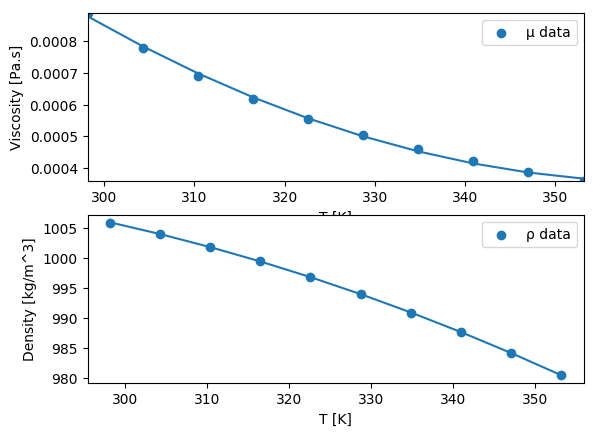

In [3]:
mu_fit  = polyfit(T, mu_water, 2)
rho_fit = polyfit(T, rho_water, 2)
subplot(2,1,1)
scatter(T, mu_water, label = "μ data") 
plot(T, polyval(mu_fit, T))
xlabel("T [K]") 
ylabel("Viscosity [Pa.s]")
legend()
axis([minimum(T), maximum(T), minimum(mu_water), maximum(mu_water)])

subplot(2,1,2)
scatter(T, rho_water, label = "ρ data") 
plot(T, polyval(rho_fit, T))
xlabel("T [K]")
ylabel("Density [kg/m^3]")
legend();

The above fit looks fine. Now we can go into the fun PDE part. The PDE's that we are going to solve read:
$$\frac{\partial}{\partial t}\left(\varphi\rho\right)+\nabla.\left(\rho\mathbf{u}\right)=0,$$
$$\mathbf{u}=-\frac{k}{\mu}\nabla p,$$
$$\begin{multline*}
\frac{\partial}{\partial t}\left(\varphi\rho c_{p,w}\left(T-T_{0}\right)+\left(1-\varphi\right)\rho_{s}c_{p,s}\left(T-T_{0}\right)\right)+\\
+\nabla.\left(-\lambda\nabla T+\rho c_{p,w}\left(T-T_{0}\right)\mathbf{u}\right)=0
\end{multline*}$$

I'm not going to the details of the above equations, and I hope there is no mistakes since I wrote them from memory. The only change that I made here is that I replace $T-T_0$ with a new variable $\theta$. 
The discretization is done as usual. You can see that the PDE's are coupled. However, I do not use a fully coupled solution. All I do is that I calculate the values of viscosity and density of water (that are temperature-dependent) from the previous time-step, find the pressure profile, then velocity field, and finally a new temperature profile by solving the energy equation. I loop through this a couple of times and update the result in each time-step.  
Let's define the domain and all the physical parameters.

## Physical parameters

In [4]:
T0    = 25.0 + 273.15  # [K] reference temperature
L     = 100            # [m]
W     = 20             # [m]
poros = 0.35           # [-]
perm  = 0.002e-12      # Darcy
V_dp  = 0.2            # Dykstra-Parsons coef
clx   = 0.1            # Correlation length in x direction
cly   = 0.1            # Correlation length in y direction
T_inj = 25 + 273.15    # [K]
theta_inj = T_inj - T0 # [K]
T_res = 80 + 273.15    # [K]
theta_res = T_res - T0 # [K]
u_inj = 1.0/(3600*24)  # [m/s]
p_res = 200e5          # [Pa]
λ_water  = PropsSI("conductivity", "T", T_res, "P", p_res, "water") # W/m/K
λ_rock   = 0.16        # [W/m/K] rock conductivity (for sandstone from my thesis)
λ_eff    = λ_water^poros*λ_rock^(1-poros) # effective conductivity
cp_water = PropsSI("CPMASS", "T", T_res, "P", p_res, "water") # J/kg/K
cp_rock  = 837.0       # [J/kg/K] rock heat capacity (for sandstone)
rho_rock = 2650.0      # [kg/m^3] rock density (for sandstone)

2650.0

## Define the domain and its boundaries

In [5]:
Nx  = 100
Ny  = 20
m   = createMesh2D(Nx, Ny, L, W)  # 2D Cartesian grid

perm_val   = permfieldlogrnde(Nx, Ny, perm, V_dp, clx, cly)
perm_field = createCellVariable(m, perm_val)
left_range  = 1:Ny
right_range = 1:Ny

BCp = createBC(m)                 # pressure boundary
BCp.left.a[left_range]   = 
    perm_field.value[2, left_range]/polyval(mu_fit, T_inj)
BCp.left.b[left_range]   = 0.0
BCp.left.c[left_range]   = -u_inj
BCp.right.a[right_range] = 0.0
BCp.right.b[right_range] = 1.0
BCp.right.c[right_range] = p_res

BCt = createBC(m)                 # temperature boundary
# Danckwertz with assumptions (density of water is almost constant)
rho_water_inj  = polyval(rho_fit, T_inj)
BCt.left.a[left_range]  = λ_eff
BCt.left.b[left_range]  = -rho_water_inj*cp_water*u_inj
BCt.left.c[left_range]  = -rho_water_inj*cp_water*u_inj*theta_inj;

Let's visualize the heterogeneous permeability field:

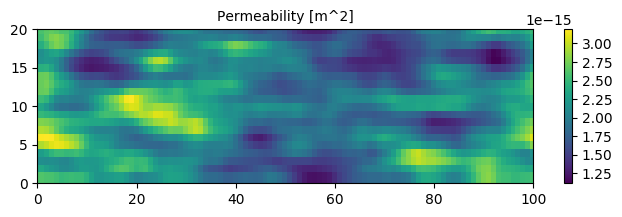

In [6]:
figure(figsize=(8,2))
visualizeCells(perm_field)
title("Permeability [m^2]", fontsize = 10)
colorbar();

## Initial conditions

In [7]:
theta_init = createCellVariable(m, theta_res, BCt)
theta_val  = createCellVariable(m, theta_res, BCt)
p_init     = createCellVariable(m, p_res, BCp)
p_val      = createCellVariable(m, p_res, BCp)
rho_init   = createCellVariable(m, 
    polyval(rho_fit, theta_init.value+T0))
rho_val    = copyCell(rho_init)
mu_init    = createCellVariable(m, 
    polyval(mu_fit, theta_init.value+T0))
mu_val     = copyCell(mu_init);

## Solver settings and discretization

In [8]:
dt         = (L/Nx)/(u_inj/poros)   # [s] time step
final_time = Nx*dt                  # [s]

# discretization
M_BCp, RHS_BCp = boundaryConditionTerm(BCp)
M_BCt, RHS_BCt = boundaryConditionTerm(BCt)
M_conductivity = diffusionTerm(-harmonicMean(
        createCellVariable(m, λ_eff)));

## Solver loop

In [9]:
for t in dt:dt:final_time
    
    for i in 1:3 # internal loop
        # solve pressure equation
        RHS_ddt_p   = constantSourceTerm(poros/dt*(rho_val - rho_init))
        water_mobil = harmonicMean(perm_field./mu_val)
        rho_face = arithmeticMean(rho_val)
        M_diff_p    = diffusionTerm(-rho_face.*water_mobil)
        p_val       = solveLinearPDE(m, M_diff_p + M_BCp,
            RHS_BCp - RHS_ddt_p)
        
        # velocity vector
        u = -water_mobil.*gradientTerm(p_val)
        
        # solve heat equation
        α                  = poros*rho_val*cp_water+(1-poros)*
            rho_rock*cp_rock
        M_trans, RHS_trans = transientTerm(theta_init, dt, α)
        M_conv             = convectionTerm(cp_water*rho_face.*u)
        theta_val          = solveLinearPDE(m, 
            M_BCt + M_conv + M_trans + M_conductivity,
            RHS_BCt + RHS_trans)
        
        # update density and viscosity values
        rho_val.value[:] = polyval(rho_fit, theta_val.value + T0)
        mu_val.value[:]  = polyval(mu_fit, theta_val.value + T0)
    end # end of inner loop
    
    rho_init   = copyCell(rho_val)
    p_init     = copyCell(p_val) # not necessary
    theta_init = copyCell(theta_val)
end

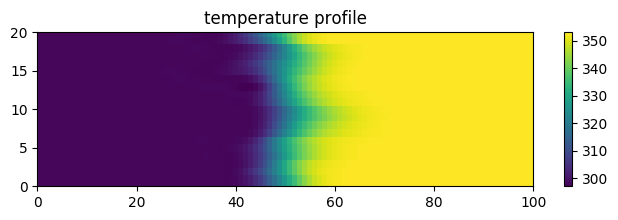

In [10]:
figure(figsize=(8,2))
visualizeCells(theta_val+T0)
title("temperature profile")
colorbar();

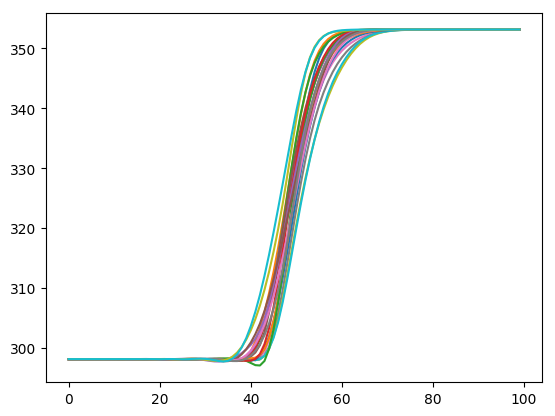

In [11]:
plot(theta_val.value[2:end-1,2:end-1]+T0);